In [4]:
import pyodbc
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [17]:
# Synapse GSK Prod

server   = "lana-sqlserver-prd-01.database.windows.net"
database = 'lana-synapse-prd-01'
driver    = '{ODBC Driver 17 for SQL Server}'
user = 'lct_9d24f4ccd9e64b7795e67089afbbc70c_prd_01_ro'
password = 'L0nx@0621gskro'
schema_name   = "lct_9d24f4ccd9e64b7795e67089afbbc70c_prd_01"
port = '1433'

#tenant_url = "https://ssplctcgauat01.jdadelivers.com"

def call_query(sql_query):
    conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+user+';PWD='+ password)
    cur = conn.cursor()
    data = pd.read_sql_query(sql_query,conn)
    return data  

In [20]:
%%time

### Testing with top 100 nodes based on revenue (sales orders)
### Latest version of Projected Inventoryis considered


SQL_1= """WITH filter_cte (
	derived_id,Revenue
	)
AS (
	SELECT TOP (3000) 
       b.derived_id 
      ,a.order_quantity * a.unit_price as 'Revenue'
  FROM [sales_order_line] a
  LEFT JOIN node_inventory b 
        ON a.supplier_item_name = b.customer_item_name
        AND a.ship_from_site_name = b. ship_to_site_name
  WHERE a. need_by_date > Dateadd(MONTH, -6, Getdate()) 
        AND a. need_by_date <= Dateadd(MONTH, 0, Getdate())
        AND a. line_status <> 'cancelled'
  ORDER BY   (a.order_quantity * a.unit_price) DESC

 )
	
	,pi_cte (
	node_inventory_derived_id
	,measure_date
	,pi
	)
AS (
	SELECT node_inventory_derived_id
		,measure_date
		,pi
	FROM (
		SELECT cast(node_inventory_derived_id AS CHAR) AS 'node_inventory_derived_id'
			,quantity AS 'pi'
			,cast(measure_date AS DATE) AS 'measure_date'
			,rank() OVER (
				PARTITION BY node_inventory_derived_id
				,measure_date ORDER BY version_date DESC
				) AS rank_
		FROM node_inventory_projected_inventory
		WHERE node_inventory_derived_id IN (
				SELECT [derived_id]
				FROM filter_cte
				)
			AND measure_date > Dateadd(MONTH, - 6, Getdate())
			AND measure_date <= Dateadd(day, 0, Getdate())
		) c
	WHERE rank_ = 1
	)
	,oh_cte (
	node_inventory_derived_id
	,measure_date
	,on_hand
	)
AS (
	SELECT node_inventory_derived_id
		,measure_date
		,on_hand
	FROM (
		SELECT cast(node_inventory_derived_id AS CHAR) AS 'node_inventory_derived_id'
			,sum(quantity) AS 'on_hand'
			,cast(measure_date AS DATE) AS 'measure_date'
		FROM node_inventory_on_hand
		WHERE node_inventory_derived_id IN (
				SELECT [derived_id]
				FROM filter_cte
				)
			AND measure_date > Dateadd(Month, - 6, Getdate())
			AND measure_date <= Dateadd(day, 0, Getdate())
		GROUP BY node_inventory_derived_id
			,measure_date
		) d
	)
	,join1_cte (
	node_inventory_derived_id
	,measure_date
	,on_hand
	,pi
	)
AS (
	SELECT COALESCE(a.node_inventory_derived_id, b.node_inventory_derived_id) AS 'node_inventory_derived_id'
		,COALESCE(a.measure_date, b.measure_date) AS measure_date
		,a.on_hand
		,b.pi
	FROM oh_cte a
	FULL OUTER JOIN pi_cte b ON a.node_inventory_derived_id = b.node_inventory_derived_id
		AND a.measure_date = b.measure_date
	)
	,join2_cte (
	node_inventory_derived_id
	,measure_date
	,pi
	,on_hand
	,variance
	,var_pc    
	)
AS (
	SELECT a.node_inventory_derived_id
		,a.measure_date
		,coalesce(a.[pi],0) as 'pi'
		,coalesce(a.on_hand,0) as 'on_hand'
		,coalesce(a.on_hand,0) - coalesce(a.[pi],0) as 'variance' 
		,((coalesce(a.on_hand,0) - coalesce(a.[pi],0))/nullif(coalesce(a.[pi],0),0)) as 'var_pc'  
	FROM join1_cte a
	LEFT JOIN filter_cte b ON a.node_inventory_derived_id = b.derived_id
	)

SELECT *
FROM join2_cte
"""

RawData = call_query(SQL_1)
#RawData['url'] = tenant_url + RawData['url'].astype(str)
RawData.head()

Wall time: 32.2 s


,node_inventory_derived_id,measure_date,pi,on_hand,variance,var_pc
0,8142297137661886803,2021-08-17,115932.0,0.0,-115932.0,-1.000000
1,-6444109849161613975,2021-11-03,-362.0,0.0,362.0,-1.000000
2,-4809007790516659147,2021-10-27,-189.0,0.0,189.0,-1.000000
3,3299270184960105979,2021-08-17,8578.0,0.0,-8578.0,-1.000000
4,-4493883922221608374,2021-12-07,9814.0,11254.0,1440.0,0.146729


In [5]:
RawData.describe()

,pi,on_hand,variance
count,5.307630e+05,5.307630e+05,5.307630e+05
mean,1.843055e+05,1.089034e+05,-7.540214e+04
std,6.351481e+05,2.450983e+05,5.804233e+05
min,-2.152308e+06,0.000000e+00,-1.352565e+07
25%,0.000000e+00,0.000000e+00,-3.288100e+04
50%,3.353100e+04,6.059000e+03,0.000000e+00
75%,2.005870e+05,1.089960e+05,1.573600e+04
max,1.370120e+07,3.998606e+07,4.065580e+07


### visualize probability plot

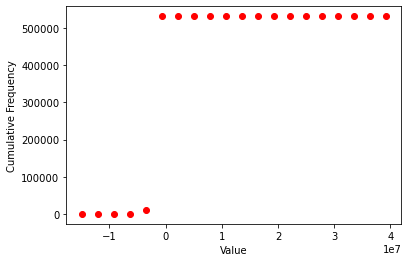

In [11]:
counts, start, dx, _ = stats.cumfreq(RawData['variance'], numbins=20)
x = np.arange(counts.size) * dx + start

plt.plot(x, counts, 'ro')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')

plt.show()

#### Normality test

In [14]:
# The Shapiro-Wilk test is a statistical test used to check if a continuous variable follows a normal distribution. 
# The null hypothesis (H0) states that the variable is normally distributed, 
# and the alternative hypothesis (H1) states that the variable is NOT normally distributed.

shapiro(RawData['variance'])

ShapiroResult(statistic=0.1876734495162964, pvalue=0.0)

#### Since we had a small sample size, determining the distribution of PI and On_hand was important for choosing appropriate statistical method. So, a Shapiro-Wilk test was performed and did not show evidence of normality (p-value<0.05). For a paired t-test to be valid on this small sample size the population would have to be approximately normal. This is not a robust condition, however. This will be still valid if we increase the sample size . Alternatively, we can run a one-sample Z test on a small sample. For a large sample, both t-test and z-test will yield similar results.

### Hypothesis Testing - Paired Sample T-Test

In [15]:
# Null hypothesis, H0 : there is no difference between PI and On_hand (mean difference between the two is 0)
# Alternate hypothesis, H1 : there is difference between PI and On_hand (mean difference between the two is not 0)
stats.ttest_rel(RawData['pi'],RawData['on_hand'])

Ttest_relResult(statistic=94.64313986057178, pvalue=0.0)

#### A paired sample t-test was used to analyze projected inventory computation & on hand inventory to test if they are significantly different.  We reject the null hypothesis since the p-value <0.05. 

## Tested at 95% confidence level, there is enough evidence to suggest that the difference between PI and On_hand in GSK Production is significant